In [16]:
import numpy as np
import json, os, pickle, random
from tqdm.notebook import tqdm
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import qiskit
from qiskit import QuantumCircuit, execute
from qiskit.compiler import transpile
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit.circuit.library import CXGate, RXGate, IGate, ZGate
from qiskit.providers.fake_provider import FakeMontreal, FakeLima
from scripts.utils import get_backend_properties_v1
from scripts.mlp import MLP1, MLP2, MLP3, encode_data
import matplotlib.pyplot as plt
import seaborn as sns
from scripts.noise_utils import AddNoise, RemoveReadoutErrors
from scripts.from_circ_to_numpy import *

In [17]:
def load_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data["train_data"], data["test_data"]

In [18]:
train_data, test_data = load_data("data/circuits/random_circ_paper_experiment_1.pkl")

In [19]:
from scripts.mlp import encode_data
from scripts.utils import get_backend_properties_v1
from qiskit.providers.fake_provider import FakeLima

backend = FakeLima()
properties = get_backend_properties_v1(backend=backend)

In [20]:
start = 14
end = 19 # 18 basically

In [21]:
train_circuits = []
train_ideal_exp_vals = []
train_noisy_exp_vals = []
for i in range(start, end):
    for circ in train_data[i]:
        train_circuits.append(circ[0])
        train_ideal_exp_vals.append(circ[2])
        train_noisy_exp_vals.append(circ[3])

In [22]:
test_circuits = []
test_ideal_exp_vals = []
test_noisy_exp_vals = []
for i in range(start, end):
    for circ in test_data[i]:
        test_circuits.append(circ[0])
        test_ideal_exp_vals.append(circ[2])
        test_noisy_exp_vals.append(circ[3])


In [23]:
X_train, y_train, X_test, y_test = load_from_json('data/features/circ_14_18')

In [24]:
X_train_rf, y_train_rf = encode_data(train_circuits, properties, train_ideal_exp_vals, train_noisy_exp_vals, num_qubits=4)
X_test_rf, y_test_rf = encode_data(test_circuits, properties, test_ideal_exp_vals, test_noisy_exp_vals, num_qubits=4)

In [25]:
len(X_train_rf[0])

58

In [26]:
from scripts.model_test_ignore_2 import *
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm.auto import tqdm
import json, os


sequence_input_size = 7
sequence_hidden_size = 4
sequence_num_layers = 4
sequence_model_type = 'LSTM'
sequence_dropout = 0.1
ann_hidden_layers = 2
ann_hidden_units = 64
ann_dropout = 0
noisy_first = True

num_epochs = 4

In [27]:
y_training = []
for y in range(4):
    temp = []
    for i in range(len(y_train)):
        temp.append(y_train[i][y])
    y_training.append(temp)

y_training = torch.tensor(y_training)

In [28]:
y_testing = []
for y in range(4):
    temp = []
    for i in range(len(y_test)):
        temp.append(y_test[i][y])
    y_testing.append(temp)

y_testing = torch.tensor(y_testing)

In [29]:
train_noisy_exp_vals = torch.tensor(train_noisy_exp_vals)
test_noisy_exp_vals = torch.tensor(test_noisy_exp_vals)

In [30]:
model_list = []
for q in range(4):
    sequence_model = create_models(sequence_input_size, 
                                        sequence_hidden_size, 
                                        sequence_num_layers, 
                                        sequence_model_type, 
                                        sequence_dropout, 
                                        ann_hidden_layers, 
                                        ann_hidden_units, 
                                        ann_dropout)
    loss_fn = nn.MSELoss() # leave for now
    optimizer = optim.Adam(sequence_model.parameters(), lr=0.01)  

    train_losses, test_losses = train_and_test_step(sequence_model, loss_fn, optimizer, X_train, train_noisy_exp_vals[:, q], y_training[q], X_test, test_noisy_exp_vals[:, q], y_testing[q], num_epochs, x_rf_train=X_train_rf, x_rf_test=X_test_rf)

    model_list.append((sequence_model))

Epoch 1/4, train loss (PyTorch): 0.1738, test_loss (scikitlearn rmse): 0.1307


c:\Users\andre\Desktop\programovanie\python\qemmarble\scripts\model_test_ignore_2.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.concat((x, torch.tensor(x_rf)))


Epoch 2/4, train loss (PyTorch): 0.1229, test_loss (scikitlearn rmse): 0.1233


c:\Users\andre\Desktop\programovanie\python\qemmarble\scripts\model_test_ignore_2.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.concat((x, torch.tensor(x_rf)))


Epoch 3/4, train loss (PyTorch): 0.1215, test_loss (scikitlearn rmse): 0.1234


c:\Users\andre\Desktop\programovanie\python\qemmarble\scripts\model_test_ignore_2.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.concat((x, torch.tensor(x_rf)))


Epoch 4/4, train loss (PyTorch): 0.1214, test_loss (scikitlearn rmse): 0.1228


c:\Users\andre\Desktop\programovanie\python\qemmarble\scripts\model_test_ignore_2.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.concat((x, torch.tensor(x_rf)))


Epoch 1/4, train loss (PyTorch): 0.1865, test_loss (scikitlearn rmse): 0.1310


c:\Users\andre\Desktop\programovanie\python\qemmarble\scripts\model_test_ignore_2.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.concat((x, torch.tensor(x_rf)))


Epoch 2/4, train loss (PyTorch): 0.1244, test_loss (scikitlearn rmse): 0.1183


c:\Users\andre\Desktop\programovanie\python\qemmarble\scripts\model_test_ignore_2.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.concat((x, torch.tensor(x_rf)))


Epoch 3/4, train loss (PyTorch): 0.1218, test_loss (scikitlearn rmse): 0.1233


c:\Users\andre\Desktop\programovanie\python\qemmarble\scripts\model_test_ignore_2.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.concat((x, torch.tensor(x_rf)))


Epoch 4/4, train loss (PyTorch): 0.1223, test_loss (scikitlearn rmse): 0.1213


c:\Users\andre\Desktop\programovanie\python\qemmarble\scripts\model_test_ignore_2.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.concat((x, torch.tensor(x_rf)))


Epoch 1/4, train loss (PyTorch): 0.1711, test_loss (scikitlearn rmse): 0.1321


c:\Users\andre\Desktop\programovanie\python\qemmarble\scripts\model_test_ignore_2.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.concat((x, torch.tensor(x_rf)))


Epoch 2/4, train loss (PyTorch): 0.1231, test_loss (scikitlearn rmse): 0.1268


c:\Users\andre\Desktop\programovanie\python\qemmarble\scripts\model_test_ignore_2.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.concat((x, torch.tensor(x_rf)))


Epoch 3/4, train loss (PyTorch): 0.1224, test_loss (scikitlearn rmse): 0.1280


c:\Users\andre\Desktop\programovanie\python\qemmarble\scripts\model_test_ignore_2.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.concat((x, torch.tensor(x_rf)))


Epoch 4/4, train loss (PyTorch): 0.1222, test_loss (scikitlearn rmse): 0.1261


c:\Users\andre\Desktop\programovanie\python\qemmarble\scripts\model_test_ignore_2.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.concat((x, torch.tensor(x_rf)))


Epoch 1/4, train loss (PyTorch): 0.1769, test_loss (scikitlearn rmse): 0.1302


c:\Users\andre\Desktop\programovanie\python\qemmarble\scripts\model_test_ignore_2.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.concat((x, torch.tensor(x_rf)))


Epoch 2/4, train loss (PyTorch): 0.1227, test_loss (scikitlearn rmse): 0.1230


c:\Users\andre\Desktop\programovanie\python\qemmarble\scripts\model_test_ignore_2.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.concat((x, torch.tensor(x_rf)))


Epoch 3/4, train loss (PyTorch): 0.1207, test_loss (scikitlearn rmse): 0.1223


c:\Users\andre\Desktop\programovanie\python\qemmarble\scripts\model_test_ignore_2.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.concat((x, torch.tensor(x_rf)))


Epoch 4/4, train loss (PyTorch): 0.1209, test_loss (scikitlearn rmse): 0.1224


In [31]:
y_test_tensor_proper = torch.ones(test_noisy_exp_vals.shape)
for i in range(len(y_test_tensor_proper)):
    for y in range(len(y_test_tensor_proper[0])):
        y_test_tensor_proper[i][y] = y_test[i][y]

RMSE_noisy_0: 0.1747466191258303
RMSE_mitigated_0: 0.12335021281516848
RMSE_noisy_1: 0.17247133147663646
RMSE_mitigated_1: 0.11759498941334644
RMSE_noisy_2: 0.17222342082773434
RMSE_mitigated_2: 0.12586789974655122
RMSE_noisy_3: 0.1743177824492419
RMSE_mitigated_3: 0.12244012359377303
RMSE_noisy: 0.17344331713621883
RMSE_mitigated: 0.12235008029108388


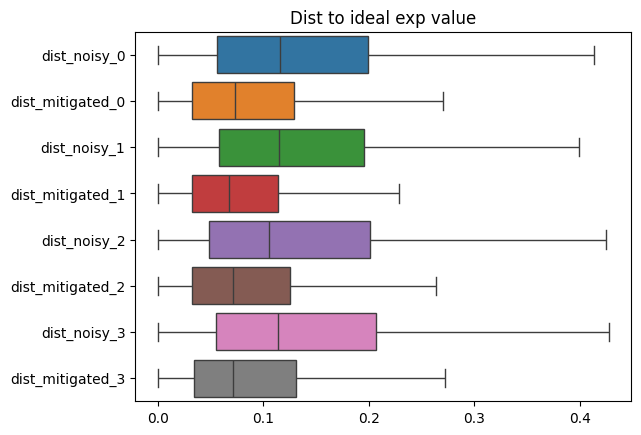

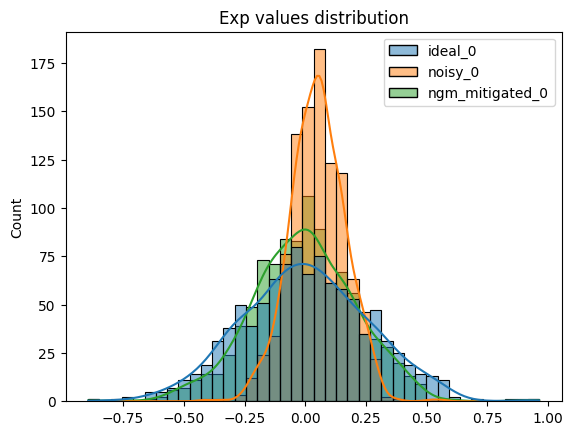

In [35]:
from scripts.mbd_utils import calc_imbalance
distances = []

num_spins = 4
even_qubits = np.linspace(0, num_spins, int(num_spins/2), endpoint=False)
odd_qubits = np.linspace(1, num_spins+1, int(num_spins/2), endpoint=False)

out = []
for q, model in enumerate(model_list):
    model_output = []
    for i in range(len(X_test)):
        model_output.append(float(run_models(sequence_model, X_test[i], test_noisy_exp_vals[i][q], X_test_rf[i]).detach().cpu().numpy()))
    out.append(model_output)
out = np.array(out).transpose()
# out = rfr.predict(batch_X[:, -4:])

for ideal, noisy, ngm_mitigated in zip(
    y_test_tensor_proper.tolist(),
    test_noisy_exp_vals.tolist(),
    out.tolist()
):
    imbalance_ideal = calc_imbalance([ideal], even_qubits, odd_qubits)[0]
    imbalance_noisy = calc_imbalance([noisy], even_qubits, odd_qubits)[0]
    imbalance_mitigated = calc_imbalance([ngm_mitigated], even_qubits, odd_qubits)[0]
    for q in range(4):
        ideal_q = ideal[q]
        noisy_q = noisy[q]
        ngm_mitigated_q = ngm_mitigated[q]
        distances.append({
            f"ideal_{q}": ideal_q,
            f"noisy_{q}": noisy_q,
            f"ngm_mitigated_{q}": ngm_mitigated_q,
            f"dist_noisy_{q}": np.abs(ideal_q - noisy_q),
            f"dist_mitigated_{q}": np.abs(ideal_q - ngm_mitigated_q),
            f"dist_sq_noisy_{q}": np.square(ideal_q - noisy_q),
            f"dist_sq_mitigated_{q}": np.square(ideal_q - ngm_mitigated_q),
            "imb_ideal": imbalance_ideal,
            "imb_noisy": imbalance_noisy,
            "imb_ngm": imbalance_mitigated,
            "imb_diff": imbalance_ideal - imbalance_mitigated
        })

plt.style.use({'figure.facecolor':'white'})

df = pd.DataFrame(distances)

for q in range(4):
    print(f'RMSE_noisy_{q}:', np.sqrt(df[f"dist_sq_noisy_{q}"].mean()))
    print(f'RMSE_mitigated_{q}:', np.sqrt(df[f"dist_sq_mitigated_{q}"].mean()))

print(f'RMSE_noisy:', np.sqrt(np.mean([df[f"dist_sq_noisy_{q}"].mean() for q in range(4)])))
print(f'RMSE_mitigated:', np.sqrt(np.mean([df[f"dist_sq_mitigated_{q}"].mean() for q in range(4)])))

sns.boxplot(data=df[["dist_noisy_0", "dist_mitigated_0", "dist_noisy_1", "dist_mitigated_1", "dist_noisy_2", "dist_mitigated_2", "dist_noisy_3", "dist_mitigated_3"]], orient="h", showfliers = False)
plt.title("Dist to ideal exp value")
plt.show()

sns.histplot([df['ideal_0'], df['noisy_0'], df["ngm_mitigated_0"]], kde=True, bins=40)
plt.title("Exp values distribution")
plt.show()